In [65]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import sklearn.metrics as skmetrics #For evaluation metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import datetime
import warnings                               
warnings.filterwarnings('ignore')

In [57]:
train = pd.read_csv('train.csv', parse_dates=['Datetime'])
train = train.set_index("Datetime")
train.tail()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2020-03-15 23:10:00+00:00,272.852287,23.500851,43.740629,-0.524250,-0.108540,-0.108540,63.668076,56.801410,1029.697556,64.904780,64.000634,35.012077,35.406250,182.0,54.889963,9.243551,2.0,182.0,5.156629
2020-03-15 23:20:00+00:00,295.675931,23.409183,43.529209,-0.684376,-0.168882,-0.168882,63.361840,56.551527,1032.996150,64.109157,63.189782,35.004216,35.280933,182.0,60.673948,9.269149,2.0,182.0,5.257433
2020-03-15 23:30:00+00:00,295.127333,23.336964,43.331115,-0.743521,-0.292512,-0.292512,63.156279,56.393276,1031.935870,63.740245,62.798514,35.003815,35.140925,182.0,59.551241,9.252811,2.0,182.0,5.188531
2020-03-15 23:40:00+00:00,342.942216,23.310323,43.169442,-0.955621,-0.516466,-0.516466,63.191997,56.273992,1047.165900,63.657965,62.699627,35.003815,35.093750,182.0,69.460091,9.385111,2.0,182.0,5.408458
2020-03-15 23:50:00+00:00,374.401860,23.297918,43.050359,-0.997635,-0.557849,-0.557849,63.424068,56.175566,1071.970544,63.752799,62.803517,35.003815,35.039062,182.0,75.836758,9.609502,2.0,182.0,5.637122


In [61]:
#let's work on the daily average
train_daily = train.resample('1D').mean()
train_daily.interpolate(method ='linear', limit_direction ='backward', inplace=True)
# train_daily.fillna(train_daily.mean(numeric_only=True), inplace=True)  # Alternative filling of missing values
train_daily['date'] = train_daily.index
train_daily["date"] = pd.to_datetime(train_daily["date"]).dt.date
train_daily.tail()
# print(train_daily.shape)
# train_daily.isna().sum()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed,date
Datetime,,,,,,,,,,,,,,,,,,,,
2020-03-11 00:00:00+00:00,466.289248,28.276232,44.059155,0.482881,0.934002,0.934002,64.106761,56.921031,1163.017505,67.939614,67.174603,38.635532,39.955577,183.729298,71.852813,10.420975,2.030612,183.729298,5.385570,2020-03-11
2020-03-12 00:00:00+00:00,570.315539,29.094133,44.476550,1.206977,1.629283,1.629283,64.051326,56.194520,1217.638162,70.008635,69.288543,39.978688,40.757739,180.773250,84.040654,10.931663,2.033333,180.773250,5.693483,2020-03-12
2020-03-13 00:00:00+00:00,619.637333,30.088163,45.903233,2.168904,2.609776,2.609776,65.348205,57.663415,1213.959374,72.745844,72.096953,39.562485,41.600482,187.621975,99.693231,10.884414,2.059259,187.621975,5.765318,2020-03-13
2020-03-14 00:00:00+00:00,800.312824,29.395626,45.924987,3.361067,3.771943,3.771943,65.975734,57.703463,1283.600520,79.347426,78.702074,39.610160,41.525481,177.635623,141.418250,11.506644,2.032787,177.635623,6.217917,2020-03-14
2020-03-15 00:00:00+00:00,787.305117,28.176449,45.640587,0.413934,0.861263,0.861263,66.482961,57.333608,1323.757190,77.001938,76.298839,38.031759,40.559243,163.307061,121.420402,11.870329,2.015748,163.307061,6.458906,2020-03-15


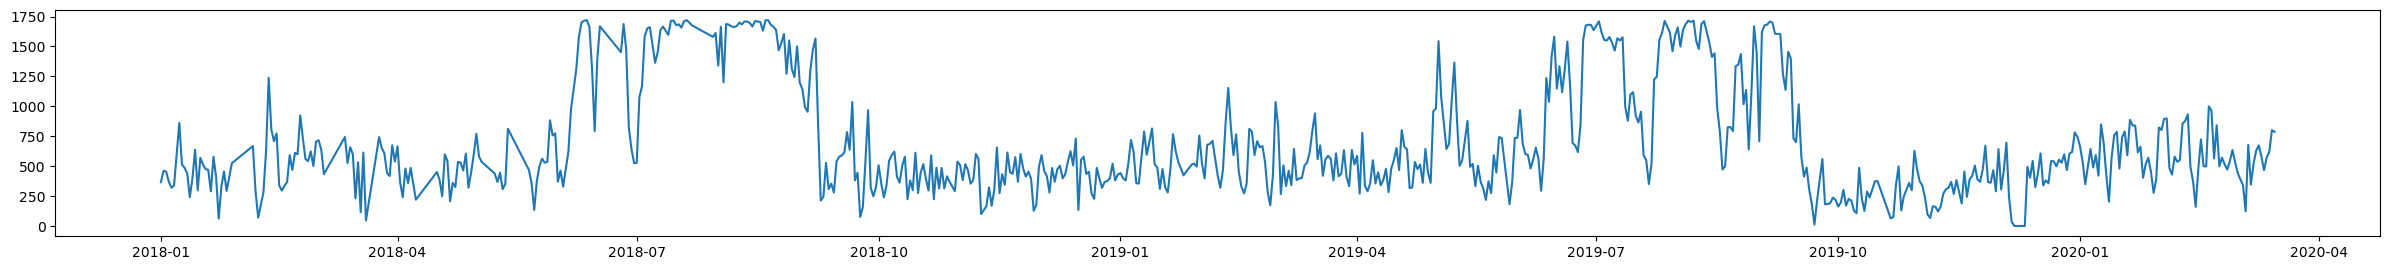

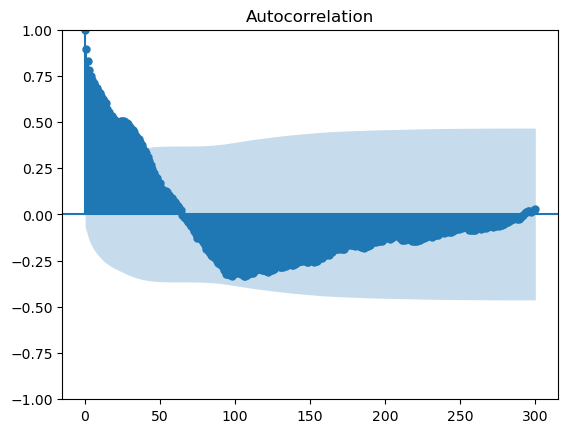

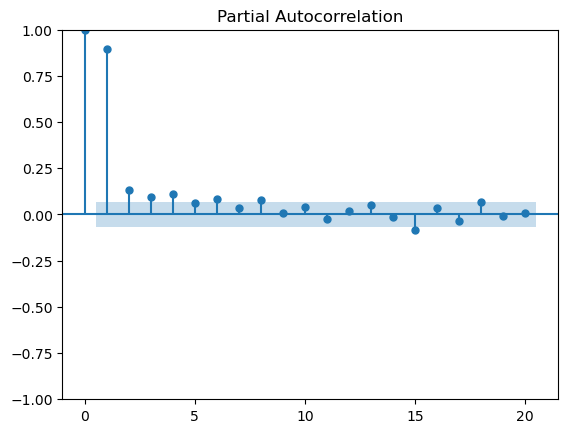

In [5]:
#visualize the data
plt.figure(figsize=(30, 10))
plt.subplot(3,1,1)
plt.plot(train_daily["ActivePower"])
plot_acf(train_daily["ActivePower"],lags=300)
plot_pacf(train_daily["ActivePower"],lags=20)
plt.show()

In [6]:
#check trend with MA smoothing
#def a moving average plot
def plotMovingAverage(series, window, plot_actual=True, scale=1.96):

    rolling_mean = series.rolling(window=window,center=True).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    if plot_actual:
        plt.plot(series[window:], label="Actual values", color='#878a88', alpha=0.5)
        
    plt.legend(loc="upper left") 
    plt.grid(True)

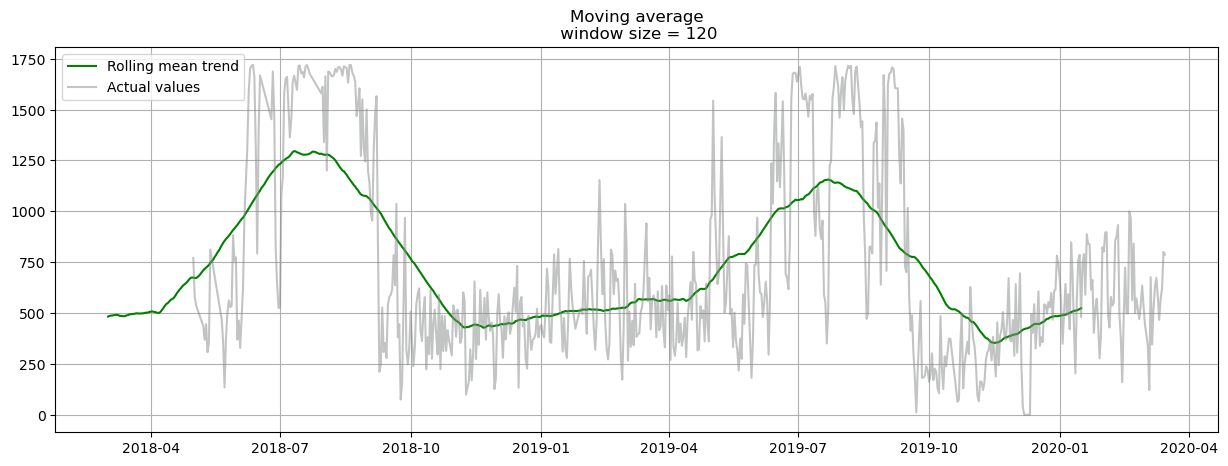

In [7]:
plotMovingAverage(train_daily["ActivePower"], 120) #yearly

# SARIMA

In [8]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [9]:
adf_test(train_daily["ActivePower"])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.260985
p-value                          0.016715
#Lags Used                       7.000000
Number of Observations Used    797.000000
Critical Value (1%)             -3.438581
Critical Value (5%)             -2.865173
Critical Value (10%)            -2.568705
dtype: float64


The Time series dont have a trend but it has a yearly seasonality

In [10]:
# define the function to difference the data ONCE
def diff(data, interval):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

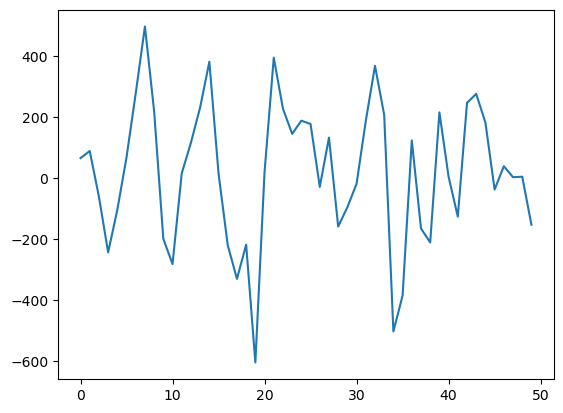

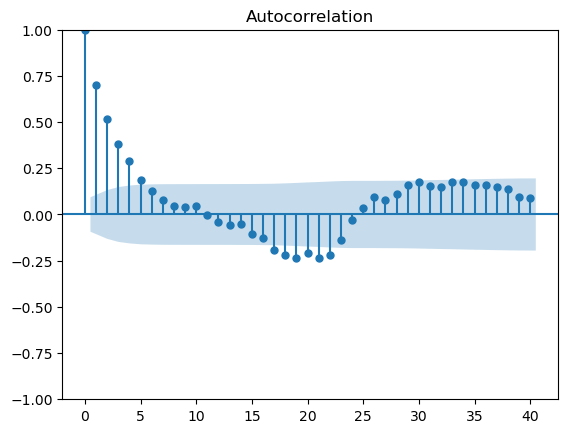

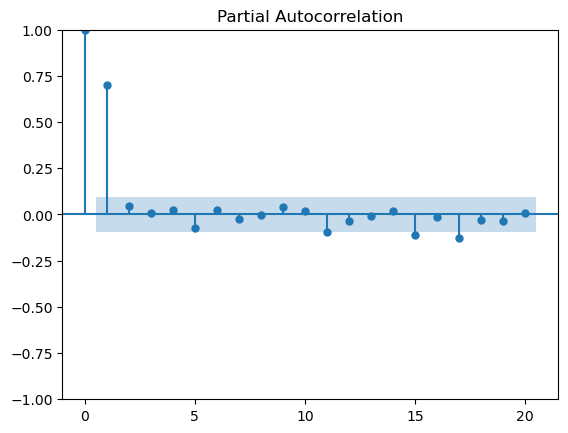

Results of Augmented Dickey-Fuller Test:
Test Statistic                -8.740795e+00
p-value                        3.012785e-14
#Lags Used                     0.000000e+00
Number of Observations Used    4.390000e+02
Critical Value (1%)           -3.445334e+00
Critical Value (5%)           -2.868146e+00
Critical Value (10%)          -2.570289e+00
dtype: float64


In [13]:
DDF1 = diff(train_daily["ActivePower"], 365)
plt.plot(DDF1[-50:])
plot_acf(DDF1 ,lags=40) 
plot_pacf(DDF1 ,lags=20) 
plt.show()
adf_test(DDF1)

In [19]:
def evaluate_models_cv(dataset, p_values, d_values, q_values, 
                       P_values, D_values, Q_values, m):
    K=5
    result = []
    best_mae, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                trend_order = (p,d,q)
                                seasonal_order = (P,D,Q,m)
                                cfg = [(p,d,q), (P,D,Q,m)]
                                validation_size=15
                                train_size=len(dataset)-validation_size*K
                                mae=0
                                for k in range(K):
                                    train, test = dataset[0:train_size+k*validation_size], dataset[
                                        train_size+k*validation_size:train_size+(k+1)*validation_size]
                                    model = ARIMA(train, order=trend_order, seasonal_order=seasonal_order) 
                                    model_fit = model.fit()
                                    predictions=model_fit.forecast(validation_size)
                                    mae = mae + skmetrics.mean_absolute_error(test, predictions)
                                mae_avg=mae/K
                                result.append((cfg, mae_avg))
                                if mae_avg < best_mae:
                                    best_mae, best_cfg = mae_avg, cfg
                                    print('ARIMA%s MAE=%.3f' % (cfg,mae_avg))
                                else:
                                    print(f'{cfg} discarded')

                            except ValueError:
                                pass
    print('Best SARIMA%s MAE=%.3f' % (best_cfg, best_mae))

In [27]:
# order selection
p=[0,1,2]
d=[0]
q=[0,1,2,3]
P=[0,1,2,3]
D=[1]
Q=[0,1,2,3]
m=9

evaluate_models_cv(train_daily["ActivePower"], p,d,q,P,D,Q,m)

ARIMA[(0, 0, 0), (0, 1, 0, 9)] MAE=188.887
ARIMA[(0, 0, 0), (0, 1, 1, 9)] MAE=168.420
[(0, 0, 0), (0, 1, 2, 9)] discarded
[(0, 0, 0), (0, 1, 3, 9)] discarded
[(0, 0, 0), (1, 1, 0, 9)] discarded
[(0, 0, 0), (1, 1, 1, 9)] discarded
[(0, 0, 0), (1, 1, 2, 9)] discarded
[(0, 0, 0), (1, 1, 3, 9)] discarded
[(0, 0, 0), (2, 1, 0, 9)] discarded
[(0, 0, 0), (2, 1, 1, 9)] discarded
[(0, 0, 0), (2, 1, 2, 9)] discarded
[(0, 0, 0), (2, 1, 3, 9)] discarded
[(0, 0, 0), (3, 1, 0, 9)] discarded
[(0, 0, 0), (3, 1, 1, 9)] discarded
[(0, 0, 0), (3, 1, 2, 9)] discarded
[(0, 0, 0), (3, 1, 3, 9)] discarded
[(0, 0, 1), (0, 1, 0, 9)] discarded
[(0, 0, 1), (0, 1, 1, 9)] discarded
[(0, 0, 1), (0, 1, 2, 9)] discarded
[(0, 0, 1), (0, 1, 3, 9)] discarded
[(0, 0, 1), (1, 1, 0, 9)] discarded
[(0, 0, 1), (1, 1, 1, 9)] discarded
ARIMA[(0, 0, 1), (1, 1, 2, 9)] MAE=166.516
[(0, 0, 1), (1, 1, 3, 9)] discarded
[(0, 0, 1), (2, 1, 0, 9)] discarded
[(0, 0, 1), (2, 1, 1, 9)] discarded
[(0, 0, 1), (2, 1, 2, 9)] discarded
[(0, 0,

In [116]:
model = ARIMA(train_daily["ActivePower"],order=(0,0,2),seasonal_order=(1,1,2,9)).fit()
pred = model.predict(start=len(train_daily["ActivePower"]),end=len(train_daily["ActivePower"])+14)
pred = pd.DataFrame(pred)
pred['date'] = pred.index
pred["date"] = pd.to_datetime(pred["date"]).dt.date
pred.to_csv('David_sarima_forecast.csv', index = False)
pred

,predicted_mean,date
2020-03-16 00:00:00+00:00,780.823559,2020-03-16
2020-03-17 00:00:00+00:00,799.526177,2020-03-17
2020-03-18 00:00:00+00:00,707.791964,2020-03-18
2020-03-19 00:00:00+00:00,590.923415,2020-03-19
2020-03-20 00:00:00+00:00,546.628360,2020-03-20
2020-03-21 00:00:00+00:00,533.526660,2020-03-21
2020-03-22 00:00:00+00:00,538.035839,2020-03-22
2020-03-23 00:00:00+00:00,699.781270,2020-03-23
2020-03-24 00:00:00+00:00,622.266628,2020-03-24
2020-03-25 00:00:00+00:00,680.193844,2020-03-25


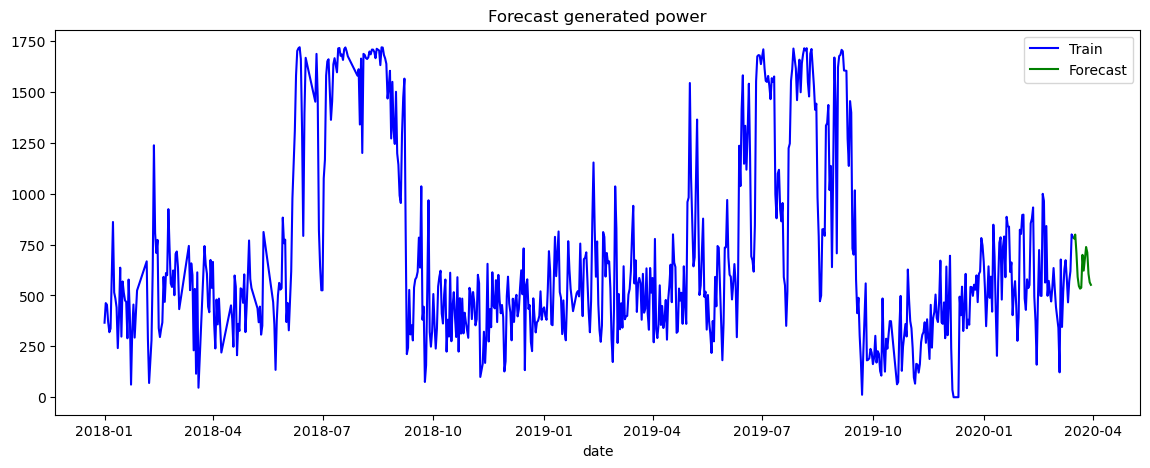

In [64]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
train_daily.plot(kind='line',x='date' , y='ActivePower', color='blue', label='Train', ax=ax)
pred.plot(kind='line', x='date', y='predicted_mean', color='green', label='Forecast', ax=ax)
plt.title('Forecast generated power')
plt.show()

# ETS

In [75]:
def evaluate_models_ETS_cv(dataset, trend="add", seasonal="add", seasonal_periods=12, damped_trend=False):
    K=5
    validation_size=15
    train_size=len(dataset)-validation_size*K
    mae=0
    for k in range(K):
        train, test = dataset[0:train_size+k*validation_size], dataset[
            train_size+k*validation_size:train_size+(k+1)*validation_size]
        model_1 = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, damped_trend=damped_trend).fit()
        predictions = pd.DataFrame(model_1.forecast(len(test)))
        mae = mae + skmetrics.mean_absolute_error(test, predictions)
    mae_avg=mae/K
    print(f"Avg MAE = {mae_avg}")
    model_1 = ExponentialSmoothing(dataset, trend="add", seasonal="add", seasonal_periods=12, damped_trend=False).fit()
    predictions = pd.DataFrame(model_1.forecast(15))
    return predictions

In [76]:
evaluate_models_ETS_cv(train_daily["ActivePower"], trend="add", seasonal="add", seasonal_periods=12, damped_trend=False)

Avg MAE = 374.4646440812861


,0
2020-03-16 00:00:00+00:00,746.603907
2020-03-17 00:00:00+00:00,798.084838
2020-03-18 00:00:00+00:00,718.214362
2020-03-19 00:00:00+00:00,749.457073
2020-03-20 00:00:00+00:00,758.895925
2020-03-21 00:00:00+00:00,843.103077
2020-03-22 00:00:00+00:00,880.004360
2020-03-23 00:00:00+00:00,810.929984
2020-03-24 00:00:00+00:00,803.396592
2020-03-25 00:00:00+00:00,862.370466


In [101]:
pred_1 = evaluate_models_ETS_cv(train_daily["ActivePower"], trend="add", seasonal="add", seasonal_periods=365, damped_trend=True)
pred_2 = evaluate_models_ETS_cv(train_daily["ActivePower"], trend="add", seasonal="add", seasonal_periods=9, damped_trend=False)
pred_3 = evaluate_models_ETS_cv(train_daily["ActivePower"], trend="add", seasonal="add", seasonal_periods=8, damped_trend=False)
pred_4 = evaluate_models_ETS_cv(train_daily["ActivePower"], trend="add", seasonal="add", seasonal_periods=2, damped_trend=True)



Avg MAE = 390.7618911651107
Avg MAE = 244.0541662979846
Avg MAE = 265.08362377860675
Avg MAE = 249.69395316588984


In [117]:
predETS = evaluate_models_ETS_cv(train_daily["ActivePower"], trend="add", seasonal="add", seasonal_periods=9, damped_trend=False)
predETS.to_csv('David_ETS_forecast.csv', index = False)
predETS

Avg MAE = 244.0541662979846


,0
2020-03-16 00:00:00+00:00,746.603907
2020-03-17 00:00:00+00:00,798.084838
2020-03-18 00:00:00+00:00,718.214362
2020-03-19 00:00:00+00:00,749.457073
2020-03-20 00:00:00+00:00,758.895925
2020-03-21 00:00:00+00:00,843.103077
2020-03-22 00:00:00+00:00,880.004360
2020-03-23 00:00:00+00:00,810.929984
2020-03-24 00:00:00+00:00,803.396592
2020-03-25 00:00:00+00:00,862.370466


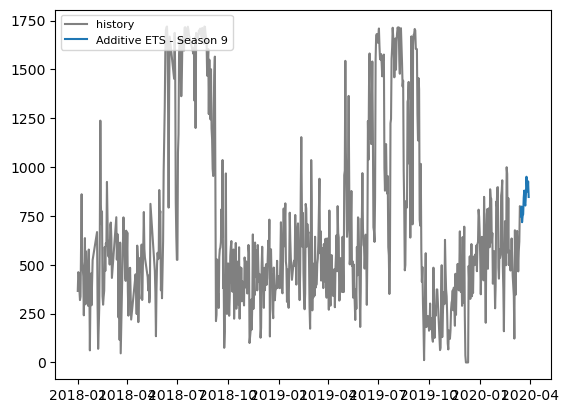

In [108]:
plt.plot(train_daily["ActivePower"], label='history', color='grey')
# plt.plot(pred_1, label='Damped additive ETS - Season 365')
plt.plot(pred_2, label='Additive ETS - Season 9')
# plt.plot(pred_3, label='Additive ETS - Season 8')
# plt.plot(pred_4, label='Damped additive ETS - Season 2')
plt.legend(loc='upper left', fontsize=8)
plt.show()

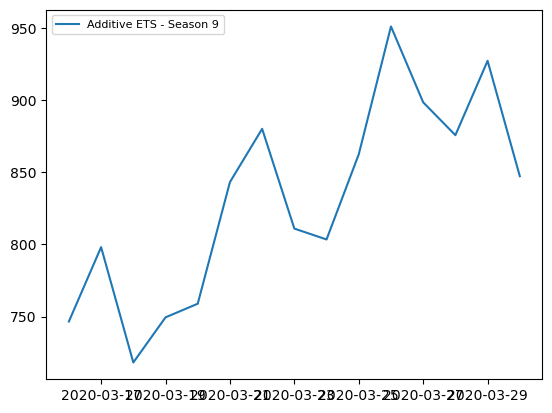

In [111]:
# plt.plot(pred_1, label='Damped additive ETS - Season 365')
plt.plot(pred_2, label='Additive ETS - Season 9')
# plt.plot(pred_3, label='Additive ETS - Season 8')
# plt.plot(pred_4, label='Damped additive ETS - Season 2')
plt.legend(loc='upper left', fontsize=8)
plt.show()